In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import json

In [ ]:
def imshow(image):
    # print(f'Shape = {image.shape}, min value = {np.min(image)}, max value = {np.max(image)}')
    image = np.reshape(image, (image.shape[0], image.shape[1], -1))
    plt.figure(figsize=(20, 10))
    if image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image, vmin=0)
    else:
        plt.imshow(image, cmap='gray', vmin=0)
    plt.show()
    
def constraint_range_01(image):
    image = (image - np.min(image))/(np.max(image) - np.min(image))
    return image

def constraint_min_0(image):
    image = (image - np.min(image))
    return image

def constraint_cut_0(image):
    image[image < 0] = 0
    return image

In [ ]:
def add_rain(image_name, rain_level, rain_pattern, alpha=0.01, beta=0.005, a=0.01, show_disparity=False, show_depth_raw=False, show_depth=False, show_pattern=False, show_rain_intensity=False, show_rain=False, show_fog=False, show_original=False, show_sample=False):    
    camera_calibration_path = 'data/Cityscapes/camera_trainvaltest/camera/train/' + image_name + '_000019_camera.json'
    camera_calibration_file = open(camera_calibration_path)
    camera_calibration = json.load(camera_calibration_file)
    camera_calibration_file.close()
    baseline = camera_calibration['extrinsic']['baseline']
    fxy = (camera_calibration['intrinsic']['fx'] + camera_calibration['intrinsic']['fy'])/2

    image_path = 'data/Cityscapes/leftImg8bit_trainvaltest/leftImg8bit/train/' + image_name + '_000019_leftImg8bit.png'
    image = cv2.imread(image_path)
    
    rain_pattern_path = 'rain-rendering/data/output/cityscapes/leftImg8bit/train/cologne/rain/' + rain_level + '/rain_mask/' + rain_pattern + '_000019_leftImg8bit.png'
    R_pattern = cv2.imread(rain_pattern_path)
    R_pattern = cv2.resize(R_pattern, (2048, 1024))
    R_pattern = np.average(R_pattern, axis=2)
    R_pattern = constraint_min_0(R_pattern)/255
    # R_pattern = constraint_range_01(R_pattern)
    R_pattern = R_pattern.astype(np.float32)
    R_pattern = cv2.ximgproc.guidedFilter(image, R_pattern, 3, 1e-3)
    # R_pattern = constraint_range_01(R_pattern)
    R_pattern = constraint_cut_0(R_pattern)

    disparity_path = 'data/Cityscapes/disparity_trainvaltest/disparity/train/' + image_name + '_000019_disparity.png'
    disparity = cv2.imread(disparity_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
    disparity[disparity > 0] = (disparity[disparity > 0] - 1)/256
    if show_disparity:
        print('Disparity')
        imshow(disparity)

#     depth = baseline*fxy/disparity
#     # depth[depth == np.Inf] = 0
#     depth[depth == np.Inf] = np.average(depth[depth != np.Inf])
    
#     if show_depth_raw:
#         print('Raw depth map')
#         imshow(depth)
    
#     depth_inverted_rain_path = 'data/RainCityscapes/leftImg8bit_trainval_rain/depth_rain/train/' + image_name + '_000019_depth_rain.png'
#     depth_inverted_rain = cv2.imread(depth_inverted_rain_path).astype(np.float32)
#     depth_rain = 255 - np.average(depth_inverted_rain, axis=2)
    
    depth_refined_path = 'data/Foggy Cityscapes/depth_stereoscopic_trainvaltest/depth_stereoscopic/train/' + image_name + '_000019_depth_stereoscopic.mat'
    depth_refined = scipy.io.loadmat(depth_refined_path)
    depth_refined = depth_refined['depth_map'].astype(np.float32)
    
    depth = depth_refined

    A0 = 1.0
    d1 = 2*fxy*a

    # (4)
    A = 1 - np.exp(-beta*depth)
    A_guided = cv2.ximgproc.guidedFilter(image, A, 10, 1e-3)
    A_guided = constraint_cut_0(A_guided)
    A_guided = constraint_range_01(A_guided)
    
    # (3)
    t_r = np.exp(-alpha*np.maximum(d1, depth))
    t_r_guided = cv2.ximgproc.guidedFilter(image, t_r, 10, 1e-3)
    t_r_guided = constraint_cut_0(t_r_guided)
    t_r_guided = constraint_range_01(t_r_guided)

    # (2)
    R = np.multiply(R_pattern, t_r_guided)
    
    if show_depth:
        print('Refined depth map')
        imshow(depth)
        imshow(np.log(depth))
        
    if show_rain_intensity:
        print('Rain streaks intensity')
        # imshow(t_r)
        imshow(t_r_guided)
    
    if show_pattern:
        print('Rain pattern')
        imshow(R_pattern)

    if show_rain:
        print('Rain layer')
        imshow(R)
        
    if show_fog and show_depth:
        print('Depth map')
        imshow(depth)
        
    if show_fog:
        print('Fog layer')
        # imshow(A)
        imshow(A_guided)

    # (1)
    output = np.zeros_like(image)
    for c in range(output.shape[2]):
        output[:, :, c] = image[:, :, c]*(1 - R - A_guided) + 255*(R + A0*A_guided)

    if show_original:
        print('Original')
        imshow(image)
        
    print('Output')
    imshow(output)
    
    if show_sample:
        output_sample_path = 'data/RainCityscapes/leftImg8bit_trainval_rain/leftImg8bit_rain/train/' + image_name + '_000019_leftImg8bit_rain_alpha_0.01_beta_0.005_dropsize_0.01_pattern_6.png'
        output_sample = cv2.imread(output_sample_path)
        print('Sample')
        imshow(output_sample)

# Example 1

Disparity


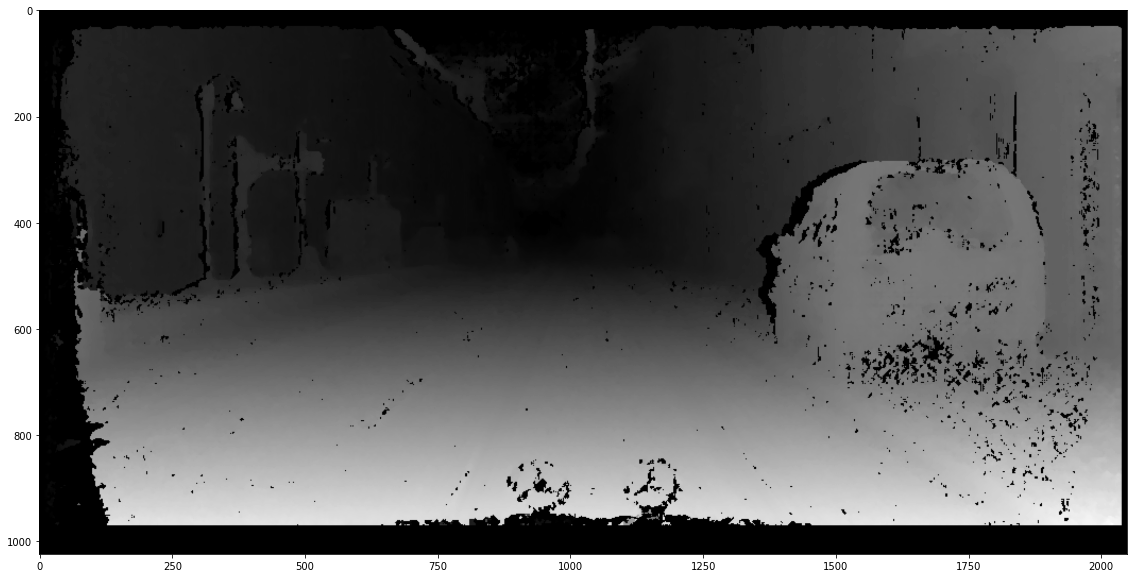

Refined depth map


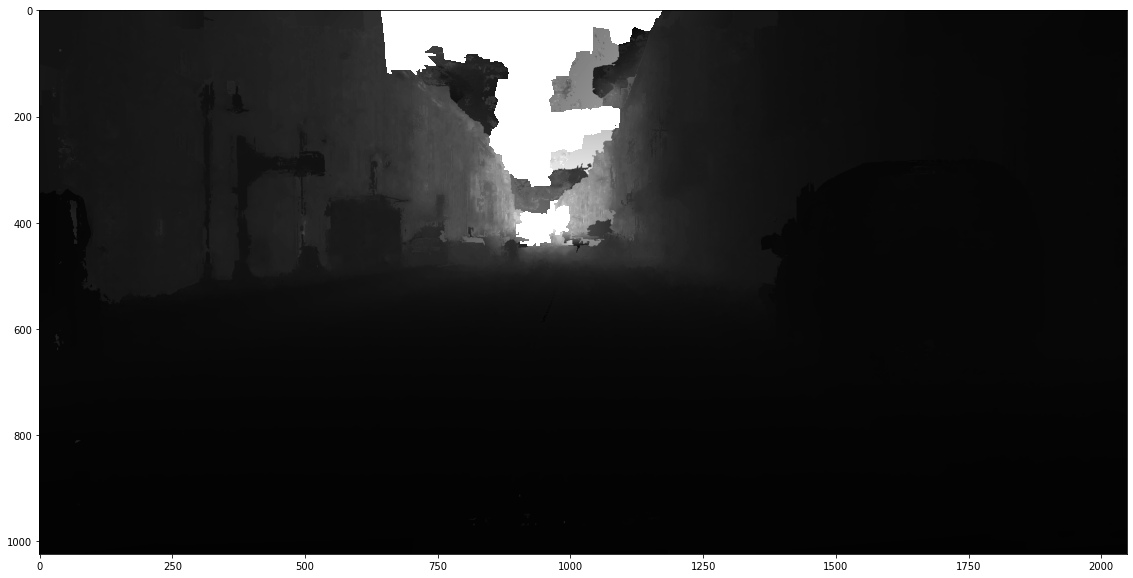

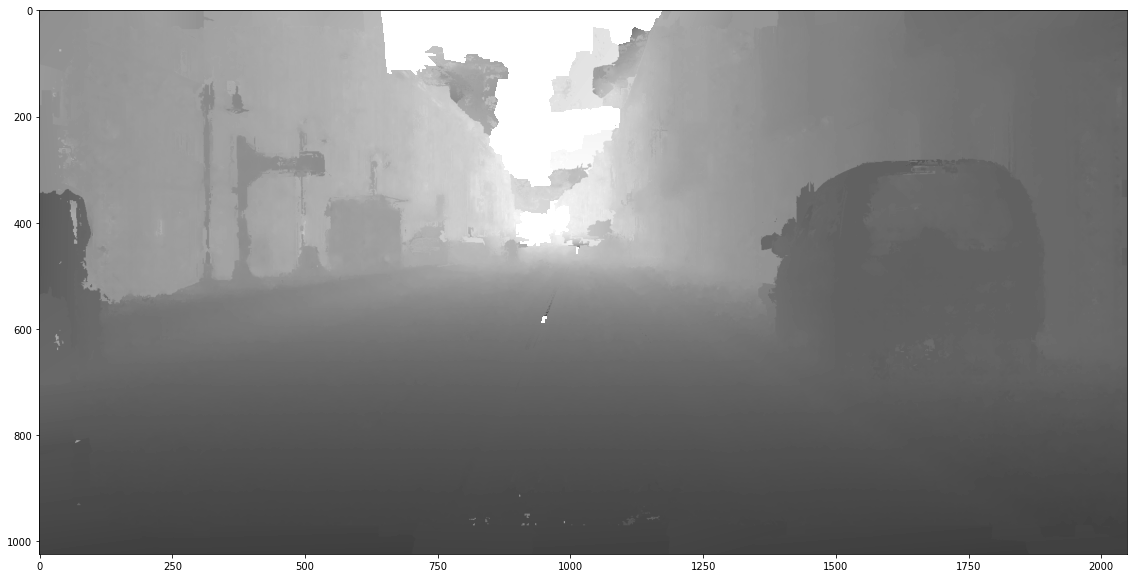

Rain streaks intensity


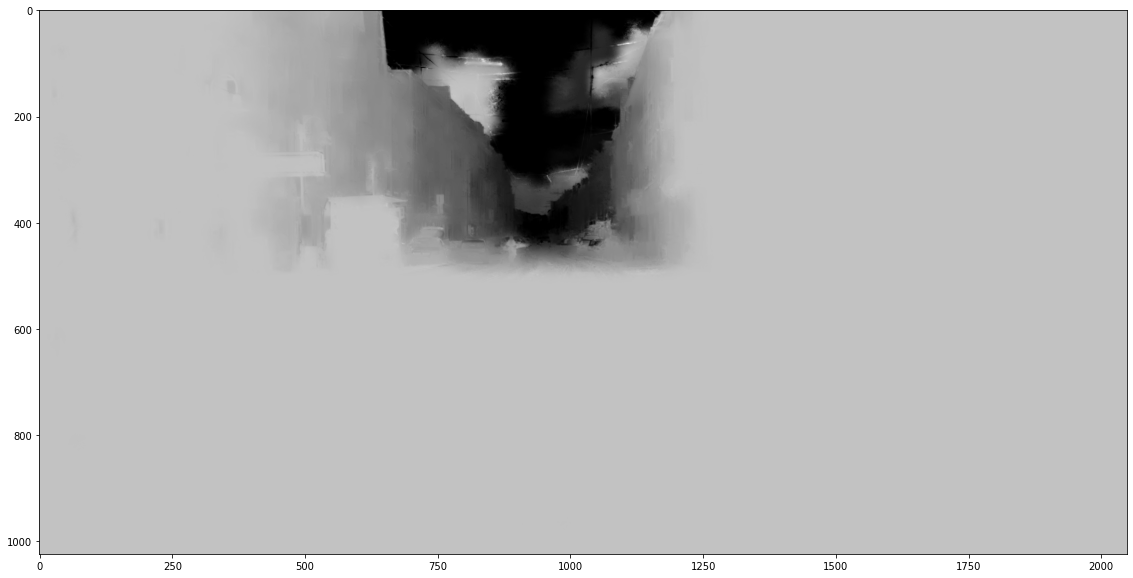

Rain pattern


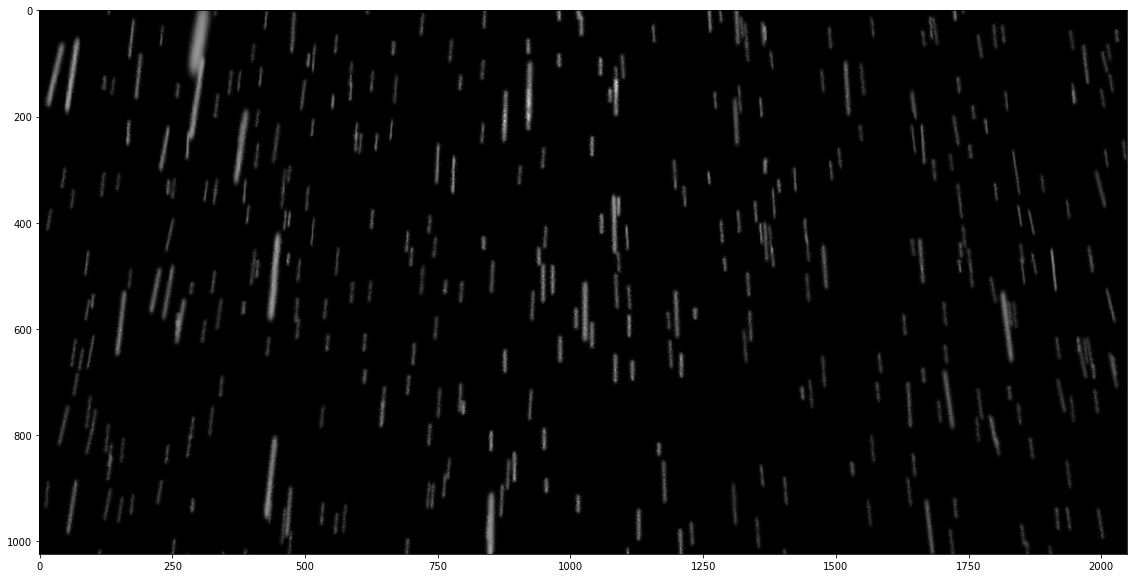

Rain layer


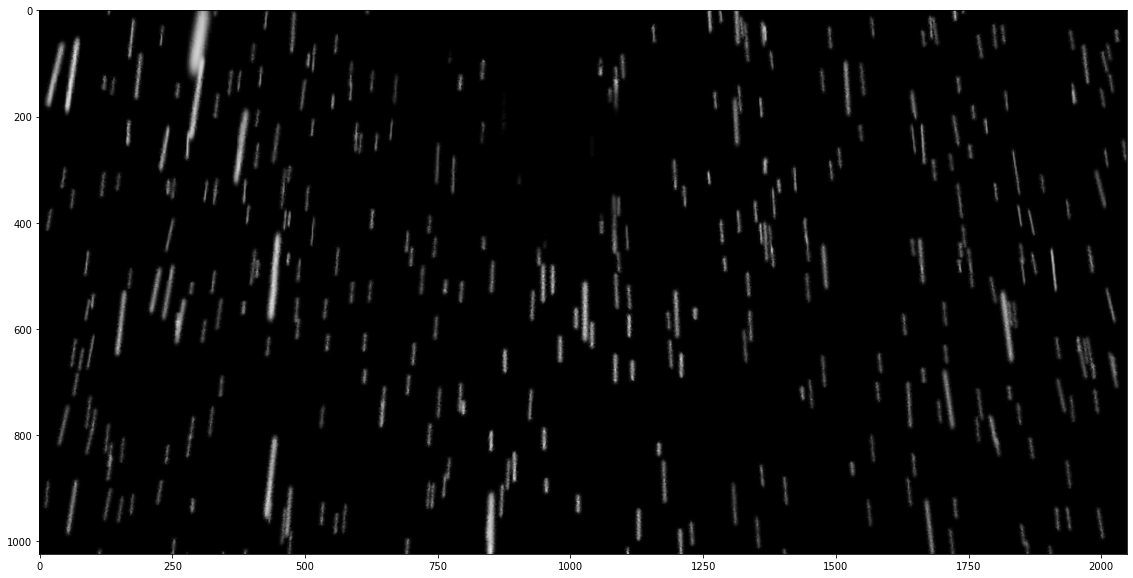

Depth map


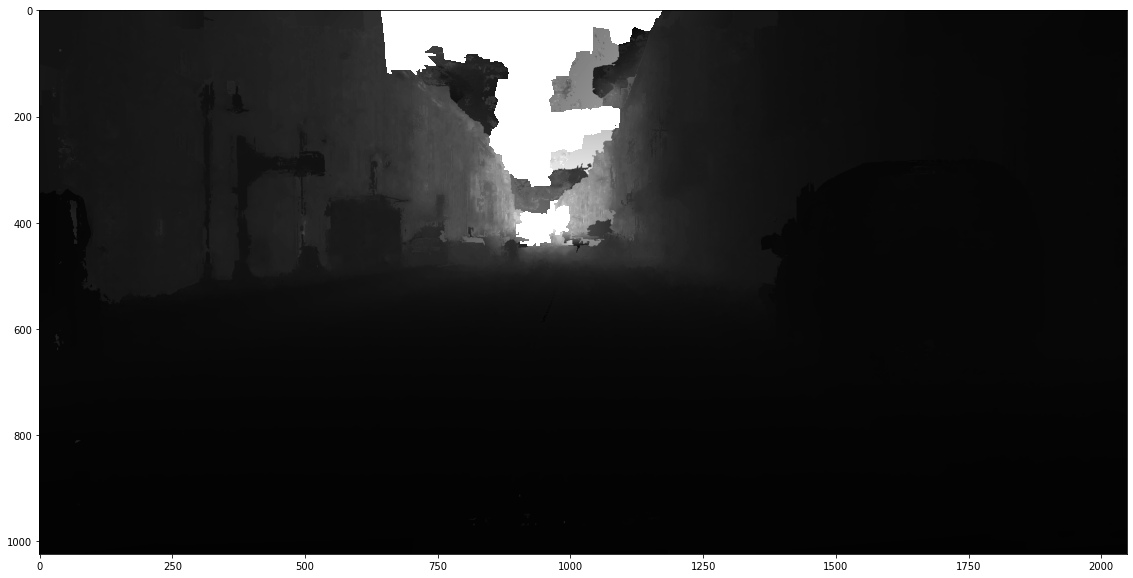

Fog layer


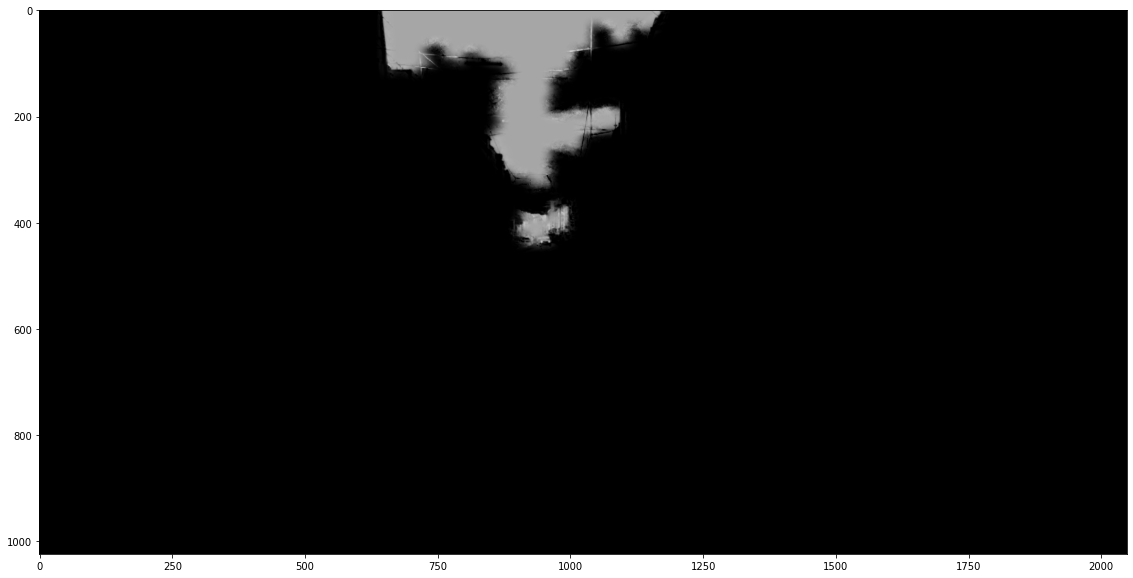

Original


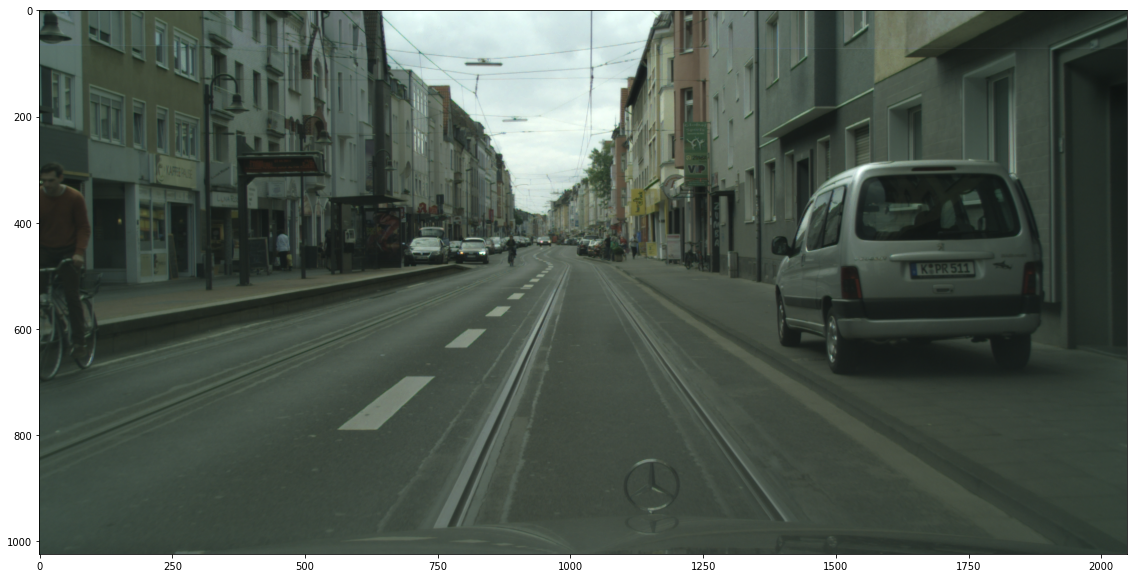

Output


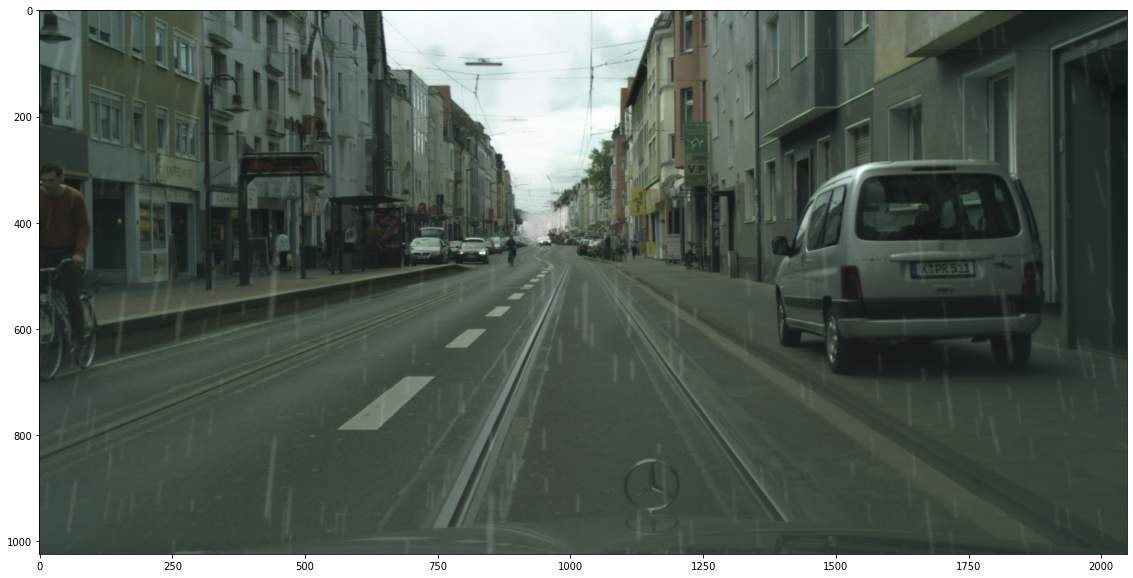

Sample


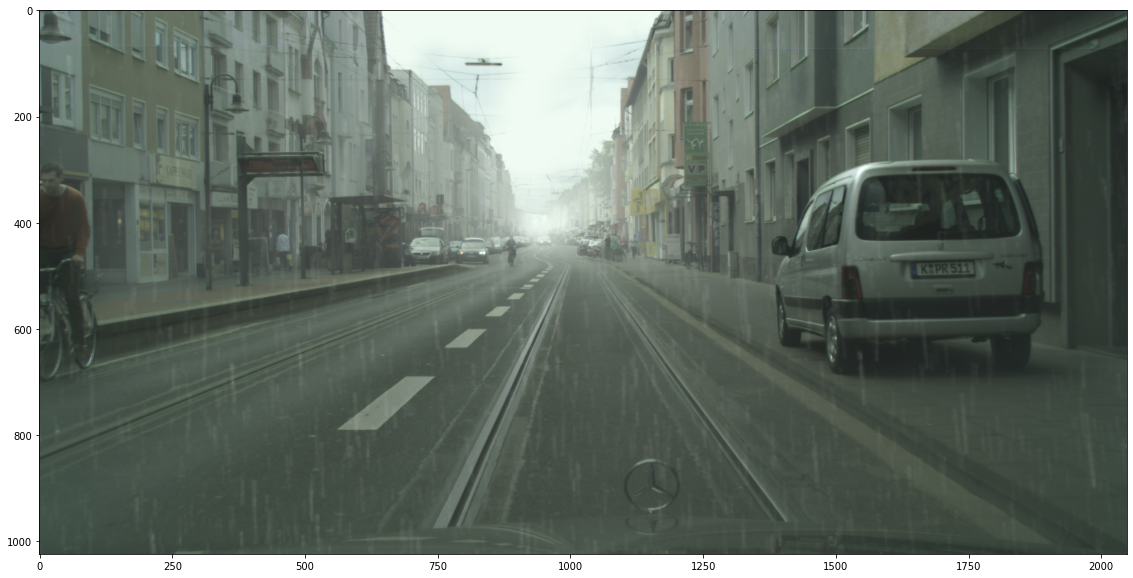

In [ ]:
image_name = 'cologne/cologne_000087'
rain_level = '20mm'
rain_pattern = 'cologne_000140'
add_rain(image_name, rain_level, rain_pattern, show_disparity=True, show_depth=True, show_pattern=True, show_rain_intensity=True, show_rain=True, show_fog=True, show_original=True, show_sample=True)

# Example 2

In [ ]:
image_name = 'cologne/cologne_000140'
rain_level = '50mm'
rain_pattern = 'cologne_000140'
add_rain(image_name, rain_level, rain_pattern, show_rain=True, show_fog=True, show_original=True, show_sample=True)

[ WARN:0@10.794] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('rain-rendering/data/output/cityscapes/leftImg8bit/train/cologne/rain/50mm/rain_mask/cologne_000140_000019_leftImg8bit.png'): can't open/read file: check file path/integrity


error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [ ]:
# image_name = 'cologne/cologne_000140'
# rain_level = '20mm'
# rain_pattern = 'cologne_000110'
# add_rain(image_name, rain_level, rain_pattern)

In [ ]:
# image_name = 'cologne/cologne_000151'
# # rain_level = '20mm'
# rain_pattern = 'cologne_000140'
# for rain_level in ['10mm', '50mm', '100mm', '200mm']:
#     add_rain(image_name, rain_level, rain_pattern, sample=False)

# Rain patterns

In [ ]:
rain_patterns = ['cologne_000000', 'cologne_000030', 'cologne_000040', 'cologne_000050', 'cologne_000110', 'cologne_000150']

image_name = 'cologne/cologne_000140'
rain_level = '50mm'
    
for rain_pattern in rain_patterns:
    add_rain(image_name, rain_level, rain_pattern)

# Rain levels

<!-- # Coefficient: alpha -->

In [ ]:
# rain_levels = ['2mm', '10mm', '50mm', '200mm']

# image_name = 'cologne/cologne_000140'
# rain_pattern = 'cologne_000140'

# for rain_level in rain_levels:
#     print(f'Rain level = {rain_level}')
#     add_rain(image_name, rain_level, rain_pattern)

# Attenuation coefficient: beta

In [ ]:
image_name = 'cologne/cologne_000140'
rain_level = '50mm'
rain_pattern = 'cologne_000140'
alpha = 0.01
a = 0.1
for beta in [0.03, 0.01, 0.001, 0.00001]:
    print(f'beta = {beta}')
    add_rain(image_name, rain_level, rain_pattern, alpha, beta, a)